# Sistema de Compressão

$ \frac{d\dot{m}}{dt} = \frac{A_1}{L_C}(\phi (N(t), \dot{m})P_1 - P_P(t)) $

$ \frac{d P_P}{dt} = \frac{C_1^2}{\nu _P}(\dot{m}(t) - \alpha (t) K_\nu \sqrt{P_P - P_{out}}) $

$ \begin{matrix} A_1 & = & 2.6\centerdot 10^{-3} m² \\
\nu _P & = & 2.0 m³ \\
L_C & = & 2.0 m \\
K_\nu & = & \frac{0.38 kg}{(kPa)^{0.5}s} \\
P_1 & = & 4.5 MPa \\
P{out} & = & 5.0 MPa \end{matrix}
$

$ \frac{d\dot{m}}{dt} = \frac{2.6\centerdot 10^{-3}}{2.0}(1.5\centerdot 4.5 - P_P) $

$ \frac{d P_P}{dt} = \frac{479.029^2}{2.0}(\dot{m} - \alpha {0.38} \sqrt{P_P - 5.0}) $

#### Importações

In [11]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from scipy.optimize import fsolve
import casadi as ca
import plotly.graph_objects as go
import optuna
from plotly.subplots import make_subplots
import time
import matplotlib.pyplot as plt

/home/matheus/.local/lib/python3.12/site-packages/matplotlib/projections/__init__.py:63: UserWarning:

Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.



#### Constantes e Variáveis Auxiliares

In [3]:
np.random.seed(42)
print(np.random.seed)

# Constantes
A1 = (2.6)*(10**-3)
Lc = 2
kv = 0.38
P1 = 4.5
P_out = 5
C = 479

timestep = 3 # Passos no passado para prever o próximo
epochs = 25000
nData = 600 # Segundos para cada alteração do Alfa
nAlphas = 5 # Número de vezes que o Alfa irá mudar, considere o treino e os testes.
alphas = np.random.uniform(0.35,0.65, nAlphas+1) # Abertura da válvula
perturb = 0
tempo = 60
dt = 0.1 # Tempo amostral

# Variáveis auxiliares
interval = [np.linspace(i * tempo, (i + 1) * tempo, nData) for i in range(nAlphas)]
massFlowrate = []
PlenumPressure = []
alpha_values = []
RNN_train = []
RNN_trainFut = []

<built-in function seed>


### Solução Numérica

##### Cálculo da Solução

In [4]:


# Condições Iniciais
def fun(variables, A1, Lc, kv, P1, P_out, C) :
    (x,y) = variables
    eqn_1 = (A1/Lc)* ((1.5 * P1) - y)*1e3
    eqn_2 = (C**2)/2 * (x - alphas[0] * kv * np.sqrt(y*1000 - P_out*1000))
    return [eqn_1, eqn_2]

result = fsolve(fun, (0, 10), args = (A1, Lc, kv, P1, P_out, C)) 

init_m = result[0] 
init_p = result[1]

# Variáveis CasADi
x = ca.MX.sym('x', 2)
alpha = ca.MX.sym('alpha', 1)

# Solução Numérica
tm1 = time.time()
for i in range(nAlphas):
    alpha_values.append(alphas[i] + np.random.normal(0,perturb,nData))

    rhs = ca.vertcat((A1/Lc)*((1.5 * P1) - x[1])*1e3, (C**2)/2 * (x[0] - alpha * kv * np.sqrt(x[1]*1000 - P_out*1000)))
    ode = {'x' : x, 'ode' : rhs, 'p' : alpha }

    F = ca.integrator('F','idas', ode, interval[0][0], dt)

    for j in range(nData):
        sol = F(x0 = [init_m, init_p], p = alpha_values[i][j])
        xf_values = np.array(sol["xf"])
        aux1, aux2 = xf_values
        massFlowrate.append(aux1)
        PlenumPressure.append(aux2)
        init_m = aux1[-1]
        init_p = aux2[-1]
        RNN_train.append([aux1[0], aux2[0], alpha_values[i][j]])
        RNN_trainFut.append([aux1[0], aux2[0], alpha_values[i][j]])
    
tm2 = time.time()

massFlowrate = np.reshape(massFlowrate, [nAlphas,nData])
PlenumPressure = np.reshape(PlenumPressure, [nAlphas,nData])

print(tm2-tm1)


0.4424443244934082


##### Gráfico do Modelo

In [5]:
fig = make_subplots(rows=1, cols=3, subplot_titles=("Vazão vs Tempo", "Pressão vs Tempo", "Alpha vs Tempo"))

for i in range(0, nAlphas):
    # Vazão
    fig.add_trace(go.Scatter(x=interval[i], y=np.squeeze(massFlowrate[i]), mode='lines',
                             name='Vazão', legendgroup='massflow', showlegend=i == 0), row = 1, col = 1)
    # Pressão
    fig.add_trace(go.Scatter(x=interval[i], y=np.squeeze(PlenumPressure[i]), mode='lines',
                             name='Pressão', legendgroup='pressure', showlegend=i == 0), row = 1, col = 2)
    # Alphas
    fig.add_trace(go.Scatter(x=interval[i], y=np.squeeze(alpha_values[i]), mode='lines', 
                             name='Alphas', line=dict(dash='dash'), legendgroup='alpha', showlegend=i == 0), row = 1, col = 3)

# Atualiza layout
fig.update_layout(
    xaxis_title='Tempo',
    grid=dict(rows=1, columns=3),
    template='plotly',
    showlegend=False
)

# Mostra a figura
fig.show()


### Rede Neural

##### Dados de Treino

In [6]:
RNN_train = np.array(RNN_train)
RNN_trainFut = np.array(RNN_trainFut)

RNN_train = np.reshape(RNN_train, (nAlphas,3,nData))
RNN_trainFut = np.reshape(RNN_trainFut,(nAlphas,3,nData))

X_train = []
y_train = []

for j in range(nAlphas):
    for i in range(len(RNN_train[0][0])):
        X_train.append(RNN_train[j,:,i])
        if i == (len(RNN_train[0][0]) - 1):
            y_train.append(RNN_trainFut[j, :2, 0])
        else:
            y_train.append(RNN_train[j,:2,i+1])

newData = int((nData*nAlphas)/timestep)

X_train = np.array(X_train)
y_train = np.array(y_train)

X_train = tf.reshape(X_train, [newData,timestep,3])
y_train = tf.reshape(y_train, [newData,timestep,2])

num_samples = X_train.shape[0]
split_index = int(num_samples * 0.75)

X_train_split = X_train[:split_index]
y_train_split = y_train[:split_index]
X_val = X_train[split_index:]
y_val = y_train[split_index:]

##### Rede

In [7]:

class NormLayer(keras.Layer):
    def call(self, inputs):
        batch_min = tf.reduce_min(inputs, axis=[1, 2], keepdims=True)
        batch_max = tf.reduce_max(inputs, axis=[1, 2], keepdims=True)
        return 2 * (inputs - batch_min) / (batch_max - batch_min) - 1, batch_min, batch_max

class DenormLayer(keras.Layer):
    def call(self, inputs, batch_min, batch_max):
        return ((inputs + 1) / 2) * (batch_max - batch_min) + batch_min

class MyModel(tf.keras.Model):
    def __init__(self, num_layers, units):
        super(MyModel, self).__init__()
        self.normalize_layer = NormLayer()
        self.denormalize_layer = DenormLayer()
        self.rnn_layers = []
        self.num_layers = num_layers
        self.units = units
        self.inputs = None

    def build(self):
        self.rnn_layers.append(keras.layers.Bidirectional(keras.layers.SimpleRNN(self.units, input_shape = (timestep,3), return_sequences=True, activation='tanh')))
        for _ in range(self.num_layers):
            self.rnn_layers.append(keras.layers.Dropout(0.2))
            self.rnn_layers.append(keras.layers.SimpleRNN(self.units, return_sequences=True, activation='tanh'))
        self.dense = keras.layers.Dense(2)

    def call(self, inputs):
        self.inputs = inputs
        normalized_inputs, batch_min, batch_max = self.normalize_layer(inputs)
        rnn_output = normalized_inputs
        for rnn_layer in self.rnn_layers:
            rnn_output = rnn_layer(rnn_output)
        dense_output = self.dense(rnn_output)
        return self.denormalize_layer(dense_output, batch_min, batch_max)

@tf.function
def lossCustom(y_true, y_pred,inputs):
    #m_t = (inputs[:, -2, 0] - 4*y_pred[:, -1, 0] + 3* y_pred[:, -2, 0])/2
    #p_t = (inputs[:, -2, 1] - 4* y_pred[:, -1, 1] + 3*y_pred[:, -2, 1])/2

    #fLoss_mass = tf.reduce_mean(tf.square(m_t - (A1/Lc)*((1.5 * P1) - y_pred[:, -2, 1]) * 1e6))
    #fLoss_pres = tf.reduce_mean(tf.square(p_t - (C**2)/2 * (y_pred[:, -2, 0] - inputs[:, -1, -1]* kv * tf.sqrt((tf.abs(y_pred[:, -2, 1] * 1000 - P_out * 1000))))))
    
    data_loss = tf.reduce_mean(tf.square(y_true[:, :, 0] - y_pred[:, :, 0])) + tf.reduce_mean(tf.square(y_true[:, :, 1] - y_pred[:, :, 1]))
    
    return data_loss #+ 1e-6*(fLoss_mass + fLoss_pres)

def create_model(lr, num_layers, units):
    model = MyModel(num_layers, units)

    def lossCustomWrapper(y_true, y_pred):
        return lossCustom(y_true, y_pred, model.inputs)

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr, clipvalue=1.0), loss=lossCustomWrapper)
    return model    

early_stopping = keras.callbacks.EarlyStopping(
    monitor='loss',  
    patience=epochs//10,     
    restore_best_weights=True 
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='loss',  
    factor=0.5,          
    patience=100,          
    min_lr=1e-8          
)

##### Treinamento

In [ ]:
def objective(trial):
    lr = trial.suggest_float('lr', 1e-6, 1e-3, log=True) 
    units = trial.suggest_int('units', 32, 64)
    batch_size = trial.suggest_int('batch_size', 16, 64) 
    num_layers = trial.suggest_int('num_layers', 0, 5)  

    model = create_model(lr, num_layers, units)

    model.fit(X_train_split, y_train_split, epochs=250, batch_size=batch_size, verbose=0)

    # Avaliação
    loss = model.evaluate(X_val, y_val, verbose=0)
    return loss

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=5)  # Ajuste o número de tentativas conforme necessário

# Exibir os melhores hiperparâmetros
print("Melhores hiperparâmetros: ", study.best_params)

In [8]:

# model = create_model(study.best_params['lr'], study.best_params['num_layers'], study.best_params['units'])
model = create_model(1e-4, 1, 30)

history = model.fit(X_train, y_train, epochs=epochs, verbose=1) #batch_size=study.best_params['batch_size']

Epoch 1/25000


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 33.3046
Epoch 2/25000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 12.8491
Epoch 3/25000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.6898
Epoch 4/25000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0753 
Epoch 5/25000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6332 
Epoch 6/25000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5766 
Epoch 7/25000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5159 
Epoch 8/25000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4682 
Epoch 9/25000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4134 
Epoch 10/25000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3856 
Epoch 11/25000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3591
Epoch 12/25000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3145 
Epoch 13/25000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2810 
Epoch 14/25000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2544
Epoch 15/25000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2

##### Dados de teste

In [9]:
massFlowrateTeste = []
PlenumPressureTeste = []
RNN_test = []
x_test = []
alpha_valuesTeste = []
alphasTeste = np.random.uniform(0.35,0.65, nAlphas) # Abertura da válvula
aux1 = []
aux2 = []

tm1 = time.time()
for i in range(0,nAlphas):
    alpha_valuesTeste.append(alphasTeste[i] + np.random.normal(0,perturb,nData))

    rhs = ca.vertcat((A1/Lc)*((1.5 * P1) - x[1])*1e3, (C**2)/2 * (x[0] - alpha * kv * np.sqrt(x[1]*1000 - P_out*1000)))
    ode = {'x' : x, 'ode' : rhs, 'p' : alpha }
    
    for j in range(nData):
        F = ca.integrator('F','idas', ode, interval[0][0], dt)
        sol = F(x0 = [init_m, init_p], p = alpha_valuesTeste[i][j])
        xf_values = np.array(sol["xf"])
        aux1, aux2 = xf_values
        massFlowrateTeste.append(aux1)
        PlenumPressureTeste.append(aux2)
        init_m = aux1[-1]
        init_p = aux2[-1]
        RNN_test.append([aux1[0], aux2[0], alpha_valuesTeste[i][j]])

tm2 = time.time()
print(tm2-tm1)

RNN_test = np.array(RNN_test)
RNN_test = np.reshape(RNN_test, (nAlphas,3,nData))

for j in range(nAlphas):
    for i in range(len(RNN_test[0][0])):
        x_test.append(RNN_test[j,:,i])

x_test = np.array(x_test)
x_test = tf.reshape(x_test, [newData,timestep,3])

2.0754354000091553


##### Gráfico Rede Neural

In [18]:
fig = make_subplots(rows=1, cols=3, subplot_titles=("Loss","Mass Flow Rate vs Time", "Plenum Pressure vs Time"))

# Loss
fig.add_trace(go.Scatter(x=list(range(1, len(history.history['loss']) + 1)), y=history.history['loss'], mode='lines', name='Mass Loss', line=dict(dash='solid')),
                  row=1, col=1)

tm1 = time.time()
# for i in range(newData):
    # inputs = np.array([temp1,temp2])
    # prediction = model.predict(inputs)
    # temp1 = x_test[:,1,:]
    # temp2 = prediction[0,:,:]
    # mass.append(prediction[:,0,:])
    # pressure.append(prediction[:,0,:])

prediction = model.predict(x_test)
mass = prediction[:,-1:,0]
pressure = prediction[:,-1,1]

tm2 = time.time()
print(tm2-tm1)

interval2 = [np.linspace(0, tempo*nAlphas, newData) for i in range(nAlphas)]

for i in range(nAlphas):
    for j in range(0, len(interval2[i]), nData):
        end = j + nData
        if end > len(interval2[i]):
            end = len(interval2[i])
        
        fig.add_trace(go.Scatter(x=interval2[i][j:end],y=np.squeeze(mass[j:end]),mode='lines',
                                line=dict(dash='solid')),row=1, col=2)
        fig.add_trace(go.Scatter(x=interval2[i][j:end],y=np.squeeze(pressure[j:end]),mode='lines',
                                line=dict(dash='solid')),row=1, col=3)
    # Modelo
    fig.add_trace(go.Scatter(x=interval[i], y=np.squeeze(massFlowrateTeste[i]), mode='lines',name='Model Mass Flow Rate', line=dict(dash='dash', color='red')),
                  row=1, col=2)
    fig.add_trace(go.Scatter(x=interval[i], y=np.squeeze(PlenumPressureTeste[i]), mode='lines', name= 'Model Plenum Pressure', line=dict(dash='dash', color='red')),
                  row=1, col=3)

fig.update_layout(
    title='Resultados Rede Neural',
    xaxis_title='Time',
    yaxis_title='Value',
    template='plotly',
    showlegend=False
)
fig.show()

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
0.07997584342956543


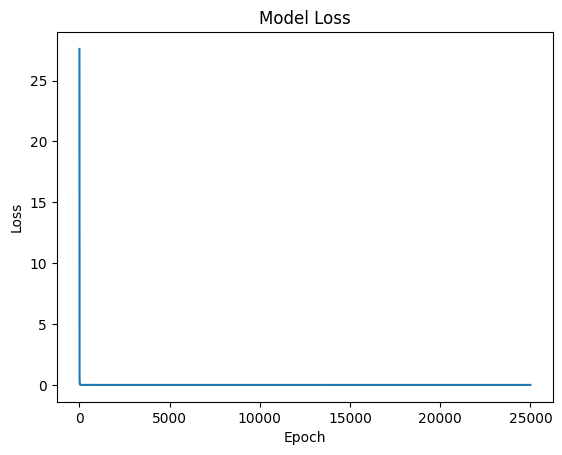

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
(1000, 3, 2)


IndexError: list index out of range

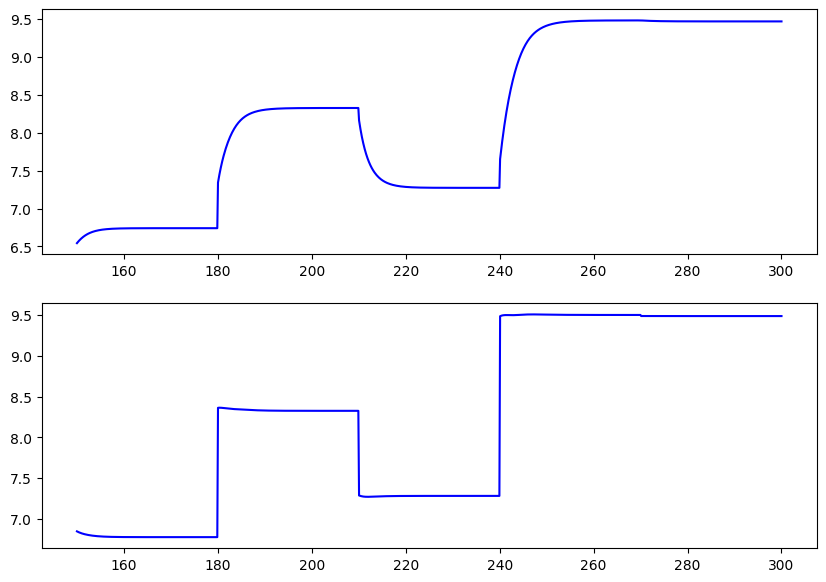

In [14]:
# Plot the training loss
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

interval2 = [np.linspace(150,300, 1000)]

# Assuming X_new is the new data for prediction
prediction = model.predict(x_test)
print(prediction.shape)

# Extraindo da Predicao
mass = prediction[:, -1, 0]
pressure = prediction[:, -1, 1]

# Cria uma figura com subplots
fig, axs = plt.subplots(2, 1, figsize=(10, 7))

# Gráfico da Mass Flow Rate vs. Tempo
axs[0].plot(interval2[0], np.squeeze(mass), label='Predicted Mass Flow Rate', color='blue')  # Gráfico da RNN em azul
axs[1].plot(interval2[0], np.squeeze(pressure), label='Predicted Plenum Pressure', color='blue')  # Gráfico da RNN em azu
for i in range(5, 10):
    axs[0].plot(interval[i], np.squeeze(massFlowrate[i]), 'r--', label='Real Mass Flow Rate' if i == 5 else "")  # Gráfico real em vermelho

axs[0].grid(True)
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Mass Flow Rate')
axs[0].set_title('Mass Flow Rate vs Time')
axs[0].legend()

# Gráfico da Pressão do Plenum vs. Tempo
axs[1].plot(interval2[0], np.squeeze(pressure), label='Predicted Plenum Pressure', color='blue')  # Gráfico da RNN em azul

for i in range(5, 10):
    axs[1].plot(interval[i], np.squeeze(PlenumPressure[i]), 'r--', label='Real Plenum Pressure' if i == 5 else "")  # Gráfico real em vermelho

axs[1].grid(True)
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Plenum Pressure')
axs[1].set_title('Plenum Pressure vs Time')
axs[1].legend()

plt.tight_layout()  # Ajusta o layout para não sobrepor os elementos
plt.show()
